# Document Vectors
This notebook is a playground on how to use gensim and the Doc2Vec model and use it to classify documents

## Resources
* https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
* https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
* http://yaronvazana.com/2018/01/20/training-doc2vec-model-with-gensim/
* https://towardsdatascience.com/understand-how-to-transfer-your-paragraph-to-vector-by-doc2vec-1e225ccf102
* https://github.com/RaRe-Technologies/gensim/blob/ca0dcaa1eca8b1764f6456adac5719309e0d8e6d/docs/notebooks/doc2vec-IMDB.ipynb

## Basic example
This example is very basic and serve as a reference on how to use gensim and train a doc2vec model.

In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Simple dataset
data = ["I love machine learning. It's awesome",
       "I love coding in python",
       "I love building software",
       "they chat amagingly well"]

# create tagged version of the documents
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
tagged_data

[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


[TaggedDocument(words=['i', 'love', 'machine', 'learning', '.', 'it', "'s", 'awesome'], tags=['0']),
 TaggedDocument(words=['i', 'love', 'coding', 'in', 'python'], tags=['1']),
 TaggedDocument(words=['i', 'love', 'building', 'software'], tags=['2']),
 TaggedDocument(words=['they', 'chat', 'amagingly', 'well'], tags=['3'])]

Notice each document was split in tokens and a dummy tag was assigned to it.

Now let's train a model with this dummy data.

In [2]:
max_epochs = 100
vec_size = 20
alpha = 0.025

# dm = 1 : Distributed Memory PV-DM
# dm = 0: Distributed BoW PV-DBOW
model = Doc2Vec(vector_size=vec_size,
               alpha=alpha,
               min_alpha=0.00025,
               min_count=1,
               dm=1)

model.build_vocab(tagged_data)

for each in range(max_epochs):
    model.train(tagged_data,
               total_examples=model.corpus_count,
               epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
    
model.save("/tmp/d2v.model")

The model is trained, now it's time to test it.

### Find the vector of a document that is no in the training data

In [3]:
model = Doc2Vec.load("/tmp/d2v.model")
# Find the vector of a document which is not in the training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print(f"Vector for {test_data}: {v1}")

Vector for ['i', 'love', 'chatbots']: [-0.01910627 -0.00333953  0.01483052  0.01896009  0.00247258  0.02179898
 -0.02117966 -0.02387159  0.01754193 -0.00556776  0.02283072 -0.01007717
  0.00454835  0.01267928 -0.02109297 -0.00803433  0.0121988  -0.02231351
  0.00245329 -0.02363222]


### Find the most similar documents by tag

In [4]:
similar_doc = model.docvecs.most_similar("1")
for doc in similar_doc:
    print(doc)

('0', 0.9877084493637085)
('2', 0.9780044555664062)
('3', 0.9771534204483032)


Here we are saying that the most similar document to document with tag '1' is the document with tag 0

### Find the vector of a document in training data using tags

In [5]:
print(model.docvecs['1'])

[-0.19321805  0.00946209 -0.05093003  0.0928799   0.00715169  0.30724257
 -0.2375986  -0.18978545 -0.38762224  0.19610381 -0.18942718 -0.0821055
  0.2865829   0.19896929 -0.45409027 -0.23266909  0.22833878 -0.23132966
  0.27640578  0.04928726]


What happens if we infer the vector of a document present in the training set?

In [6]:
doc_0 = model.docvecs['0']
sample = "I love machine learning. It's awesome"
sample_inferred = model.infer_vector(word_tokenize(sample.lower()))
print(f"Document 0:\n: {doc_0}")
print(f"\n\nInferred Document 0:\n {sample_inferred}")

Document 0:
: [-0.39761454 -0.06999756 -0.11957027  0.22177477 -0.02460292  0.4354446
 -0.4971364  -0.30891037 -0.604521    0.4129672  -0.25927463 -0.2116895
  0.49157202  0.2882661  -0.7294147  -0.44775984  0.39479092 -0.43647406
  0.37135702  0.11414798]


Inferred Document 0:
 [ 0.00837728 -0.01548042 -0.01219468  0.00750487  0.01823507 -0.00643426
  0.01237598  0.0109191  -0.03218371  0.00695342  0.0048641  -0.01628949
 -0.01639973  0.02248956 -0.01832936 -0.02789452  0.02293639  0.00057574
  0.02003899 -0.02163959]


These documents seem different, this is because the first document 0 vector is the one we obtained after training phase, and the one we obtained via `infer_vector` is reconstructing again that vector using the learned weights during training. So it is expected that both vectors does not look "similar" in appearance. However, they might be indeed similar geometrically speaking. 

Let's find the most similar tag for the new trained vector of tag 0. The tags in Doc2Vec are meant for document localization and easy access not as a class label, so we can't obtain something like a "label" for a new document. That would be the job of a supervised learning algorithm. (https://datascience.stackexchange.com/questions/10612/doc2vecgensim-how-can-i-infer-unseen-sentences-label)

Whe then will iterate over all the documents in the model and compare the similarities and sort them accordingly to get the most similar documents. This is only for ullustrative purposes, in real life this is not the best use for the doc vecs.

In [7]:
from scipy import spatial
import operator

def similarity_to(sample, model):
    tag_docs = zip(model.docvecs.doctags.keys(), model.docvecs)
    similar_docs = [(spatial.distance.cosine(sample, doc), tag, doc) for tag, doc in tag_docs]
    similar_docs = sorted(similar_docs, key=operator.itemgetter(0))
    return similar_docs

similarity_to(sample_inferred, model)

[(0.5987949073314667,
  '1',
  array([-0.19321805,  0.00946209, -0.05093003,  0.0928799 ,  0.00715169,
          0.30724257, -0.2375986 , -0.18978545, -0.38762224,  0.19610381,
         -0.18942718, -0.0821055 ,  0.2865829 ,  0.19896929, -0.45409027,
         -0.23266909,  0.22833878, -0.23132966,  0.27640578,  0.04928726],
        dtype=float32)),
 (0.6140504479408264,
  '0',
  array([-0.39761454, -0.06999756, -0.11957027,  0.22177477, -0.02460292,
          0.4354446 , -0.4971364 , -0.30891037, -0.604521  ,  0.4129672 ,
         -0.25927463, -0.2116895 ,  0.49157202,  0.2882661 , -0.7294147 ,
         -0.44775984,  0.39479092, -0.43647406,  0.37135702,  0.11414798],
        dtype=float32)),
 (0.6179295480251312,
  '3',
  array([-0.2828797 , -0.05064224, -0.14457929,  0.06179384, -0.07319915,
          0.30967024, -0.36827534, -0.14090566, -0.42585784,  0.277424  ,
         -0.22145745, -0.19932462,  0.35378993,  0.21061432, -0.50000393,
         -0.3242548 ,  0.19954048, -0.33676913,

So apparently in this case, despite reconstructing one of the training document vectors, the most similar document is #2 which is different. This might be due to the small dataset.

What happens if we use the same document vector after the training?

In [8]:
similarity_to(doc_0, model)

[(0.0,
  '0',
  array([-0.39761454, -0.06999756, -0.11957027,  0.22177477, -0.02460292,
          0.4354446 , -0.4971364 , -0.30891037, -0.604521  ,  0.4129672 ,
         -0.25927463, -0.2116895 ,  0.49157202,  0.2882661 , -0.7294147 ,
         -0.44775984,  0.39479092, -0.43647406,  0.37135702,  0.11414798],
        dtype=float32)),
 (0.011561870574951172,
  '2',
  array([-0.18245704,  0.02317899, -0.05099685,  0.08561507, -0.03265153,
          0.23538703, -0.22592573, -0.10894197, -0.23199555,  0.2065154 ,
         -0.15911505, -0.11627214,  0.2317445 ,  0.14417802, -0.28546342,
         -0.21703044,  0.16743326, -0.22026469,  0.17865147,  0.07461441],
        dtype=float32)),
 (0.012291491031646729,
  '1',
  array([-0.19321805,  0.00946209, -0.05093003,  0.0928799 ,  0.00715169,
          0.30724257, -0.2375986 , -0.18978545, -0.38762224,  0.19610381,
         -0.18942718, -0.0821055 ,  0.2865829 ,  0.19896929, -0.45409027,
         -0.23266909,  0.22833878, -0.23132966,  0.2764057

As expected, if we compare with the exact same document, we get a perfect similarity with the same document.

If we were to compare with each of the model's current vectors using the built-int functions we can do it like this:

In [9]:
model.docvecs.most_similar(positive=[sample_inferred])

[('1', 0.40120506286621094),
 ('0', 0.3859495520591736),
 ('3', 0.3820703625679016),
 ('2', 0.3293352723121643)]

We obtained the same ordering (though not the same comparison measure) as the manual compirison using the consine similarity index.

### Classifying new documents
In this section we are going to build a classifier using the generated Document vectors and the corresponding tag.

#### Resources
* https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
* https://fzr72725.github.io/2018/01/14/genism-guide.html


#### Using unique tags vs grouped tags
Essentially, if we provide unique tags for each document, gensim's Doc2Vec will generate a different document vector for each document. And if we provide $n$ duplicate tags for similar documents (like a class), we will obtain $n$ document vectors (https://fzr72725.github.io/2018/01/14/genism-guide.html) So depending of the goals and how do we want to train, we might want to use one or the other. The second option will naturally use less memory than the first one.

This example uses the customer complaints dataset from data.gov in the us.

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("/media/ohtar10/Adder-Storage/datasets/customer_compalints/Consumer_Complaints.csv")
df.rename(columns={'Consumer complaint narrative':'narrative'}, inplace=True)
df = df[['narrative', 'Product']]
df.dropna(inplace=True)
df.head()

/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


,narrative,Product
3,I am dissatisfied with the current outcome of ...,Credit card
7,On XX/XX/18 an item showed up on my credit rep...,"Credit reporting, credit repair services, or o..."
8,Saw on my credit report that there is a collec...,Debt collection
9,Capital one auto finacing XX/XX/2018 unknown i...,"Credit reporting, credit repair services, or o..."
11,I own a small trucking company. One of my truc...,Credit card or prepaid card


In [4]:
df.shape

(457289, 2)

For simplicity, let's work with the first 100,000 records first.

In [5]:
df = df.iloc[:100000]

Determine how many words do we have in the dataset

In [6]:
total_words = df.narrative.apply(lambda x: len(x.split())).sum()
print(f"Total non-unique words: {total_words:,}")

Total non-unique words: 19,523,498


### Exploring

/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


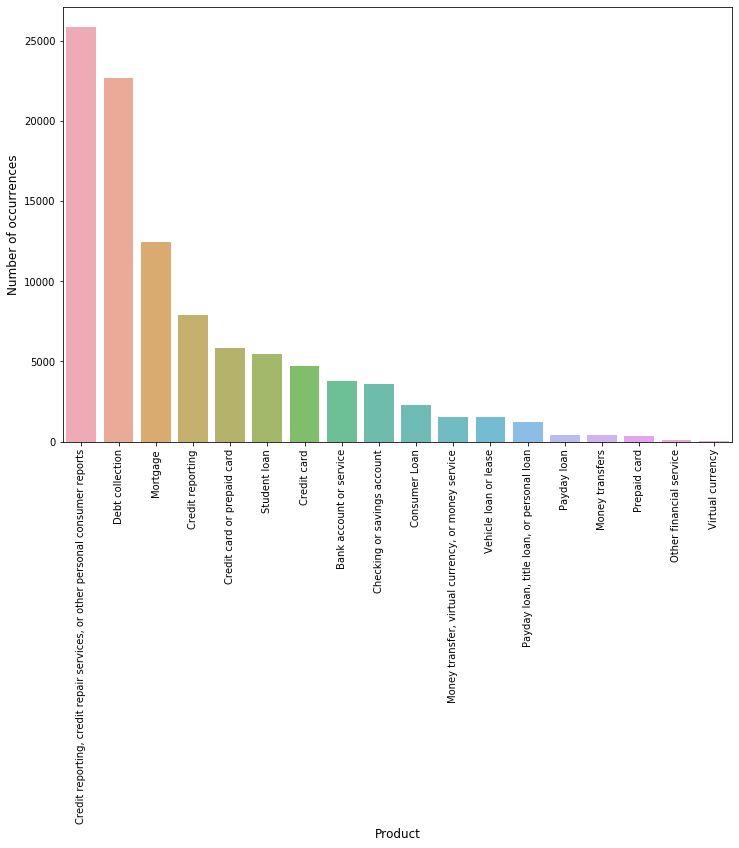

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

cnt_pro = df.Product.value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [8]:
predominant_class = cnt_pro[0]
total_docs = df.shape[0]
naive_accuracy = predominant_class / total_docs
print(f"Naive Accuracy {naive_accuracy:.2f}")

Naive Accuracy 0.26


We have imbalanced classes, but despite this, a naive classifier predicting for Credit reporting will have an accuracy of $28\%$. This is our baseline.

Now let's have a look at some examples:

In [9]:
def print_sample(df, content_col, label_col, index):
    sample = df.iloc[index][content_col]
    category = df.iloc[index][label_col]
    print(f"Sample with index {index}:\n")
    print(f"Category: {category}")
    print(f"Text:\n{sample}")

print_sample(df, 'narrative', 'Product', 0)

Sample with index 0:

Category: Credit card
Text:
I am dissatisfied with the current outcome of a dispute that was initiated with Discover Card regarding a single transaction that occurred on XXXX/XXXX/2015 in the amount of {$280.00}. I have corresponded with Discover Card at least four times since XXXX/XXXX/2015 ( which I have enclosed as an attachment to this complaint ). I believe that the credit card issuer has violated consumer protection laws by failing to implement the Special Rule for Credit Card Purchase protection despite overwhelming paperwork evidence submitted by me that shows the merchant has conducted business in bad faith less favorable to the consumer. I have sustained a monetary loss as a result of merchants bad faith and intent. I have patiently utilized the internal Discover Card dispute process over the past three months with the credit card issuer always favoring the merchant ; I have repeatedly submitted irrefutable paperwork evidence that has shown that the merc

### Text processing
Now we will proceed with the text processing part

In [10]:
from bs4 import BeautifulSoup
import re

def clear_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

df.narrative = df.narrative.apply(clear_text)
df.head()

,narrative,Product
3,i am dissatisfied with the current outcome of ...,Credit card
7,on //18 an item showed up on my credit report ...,"Credit reporting, credit repair services, or o..."
8,saw on my credit report that there is a collec...,Debt collection
9,capital one auto finacing //2018 unknown inqui...,"Credit reporting, credit repair services, or o..."
11,i own a small trucking company. one of my truc...,Credit card or prepaid card


In [11]:
%%time
import nltk
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords 

train, test = train_test_split(df, test_size=0.3, random_state=42)

# We could use word tokenize instead
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            # omit words less than 2 characters
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(lambda r: TaggedDocument(words = tokenize_text(r.narrative), tags=[r.Product]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words = tokenize_text(r.narrative), tags=[r.Product]), axis=1)

/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


CPU times: user 2min 16s, sys: 0 ns, total: 2min 16s
Wall time: 2min 16s


In [12]:
train_tagged.values[30]

TaggedDocument(words=['this', 'is', 'the', 'second', 'cfpb', 'complaint', 'am', 'filing', 'because', 'have', 'not', 'heard', 'from', 'american', 'epress', 'and', 'my', 'second', 'try', 'at', 'coming', 'to', 'resolution', 'with', 'customer', 'service', 'was', 'unsuccessful', 'recently', 'tried', 'to', 'transfer', 'membership', 'rewards', 'points', 'to', 'partner', 'airline', 'program', 'but', 'my', 'request', 'was', 'rejected', 'by', 'the', 'system', 'the', 'system', 'notified', 'me', 'that', 'my', 'point', 'transfer', 'was', 'denied', 'because', 'my', 'account', 'was', 'membership', 'rewards', 'were', 'under', 'review', 'contacted', 'membership', 'rewards', 'and', 'representative', 'tried', 'to', 'help', 'me', 'transfer', 'the', 'points', 'over', 'the', 'phone', 'they', 'were', 'unable', 'to', 'transfer', 'the', 'points', 'and', 'received', 'the', 'same', 'message', 'about', 'review', 'so', 'they', 'transferred', 'me', 'to', 'customer', 'service', 'customer', 'service', 'representative

### Train the Doc2Vec Model

In [13]:
vector_size = 1000

In [14]:
%%time
import multiprocessing
from tqdm import tqdm

cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=1, vector_size=vector_size, negative=5, hs=1, min_count=2, sample=0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 70000/70000 [00:00<00:00, 4586874.97it/s]


CPU times: user 7.51 s, sys: 0 ns, total: 7.51 s
Wall time: 7.51 s


In [123]:
%%time
from sklearn import utils

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]),
                    total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 70000/70000 [00:00<00:00, 3711163.53it/s]


CPU times: user 1h 26min 34s, sys: 55.2 s, total: 1h 27min 29s
Wall time: 11min 13s


In [124]:
model_dbow.save("../../models/gensim/customer_complain_sm.model")

In [15]:
from gensim.models import Doc2Vec
model_dbow = Doc2Vec.load("../../models/gensim/customer_complain_sm.model")

Now let's obtain the final vectors for the classification model

In [16]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [17]:
%%time

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

CPU times: user 22min 18s, sys: 151 ms, total: 22min 18s
Wall time: 22min 19s


In [37]:
%%time

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=cores, 
                            solver="saga", 
                            multi_class="multinomial", 
                            C=0.1,
                            max_iter=500,
                            l1_ratio=0.3,
                            penalty='elasticnet',
                            verbose=1,
                            random_state=42)
logreg.fit(X_train, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 190 epochs took 35 seconds
CPU times: user 35.2 s, sys: 0 ns, total: 35.2 s
Wall time: 35.2 s


[Parallel(n_jobs=12)]: Done   1 out of   1 | elapsed:   35.1s finished


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.3, max_iter=500,
                   multi_class='multinomial', n_jobs=12, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

In [38]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = logreg.predict(X_train)
training_acc = accuracy_score(y_train, y_pred)
training_f1 = f1_score(y_train, y_pred, average='weighted')

print(f"Training Accuracy {training_acc}")
print(f"Training f1-score {training_f1}")

Training Accuracy 0.27014285714285713
Training f1-score 0.11496346187850634


/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Classification with ANN

In [18]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras import backend as K

s_config = tf.ConfigProto()
#s_config.gpu_options.allow_growth = True
s_config.gpu_options.per_process_gpu_memory_fraction = 0.6
tf.keras.backend.set_session(tf.Session(config=s_config))


def show_framework_devices():
    """Just prints the devices the frameworks are using
    at the moment. It will help us to tell if they are indeed
    using GPU's or not"""
    print("Tensorflow registered devices:", device_lib.list_local_devices())
    print("Keras registered GPUs", K.tensorflow_backend._get_available_gpus())


/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ohtar10/miniconda3/envs/wtsp/lib/python3

In [19]:
show_framework_devices()

Tensorflow registered devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1680999168545174885
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10792346118958937518
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5022036787
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17542396880290598833
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14547508406937195473
physical_device_desc: "device: XLA_GPU device"
]
Keras registered GPUs ['/job:localhost/replica:0/task:0/device:GPU:0']


In [20]:
np.array(X_train).shape

(70000, 1000)

In [21]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_ann = le.fit_transform(y_train)

X_train_ann = np.array(X_train)
y_train_ann = to_categorical(y_train_ann)

#### LSTM based model

In [170]:
from keras.layers import Input, Bidirectional, Dense, LSTM, concatenate, BatchNormalization, Dropout, Embedding
from keras.models import Model
from keras import regularizers

#Define the inputs
comment_input = Input(shape=(vector_size,1), dtype='float32', name='comment_text')

#emb = Embedding(input_dim=vector_size, output_dim=300, input_length=vector_size, name="comment_embedding")(comment_input)

#Define the LSTM layer with the embedding input
x = LSTM(units=100, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01), name="comment_lstm")(comment_input)

#Apply a dense layers
x = Dense(200, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(25, activation='relu')(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(18, activation='softmax', name='prediction')(x)

model = Model(inputs=comment_input, outputs=main_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
comment_text (InputLayer)    (None, 1000, 1)           0         
_________________________________________________________________
comment_lstm (LSTM)          (None, 30)                3840      
_________________________________________________________________
dense_79 (Dense)             (None, 200)               6200      
_________________________________________________________________
batch_normalization_22 (Batc (None, 200)               800       
_________________________________________________________________
dense_80 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_32 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 100)               10100     
__________

In [171]:
%%time
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, restore_best_weights=True)

X_train_ann_rs = X_train_ann.reshape(X_train_ann.shape[0], X_train_ann.shape[1], 1)
history = model.fit(X_train_ann_rs, y_train_ann, epochs = 50, batch_size = 500, validation_split= 0.2, callbacks=[early_stopping])

Train on 56000 samples, validate on 14000 samples
Epoch 1/50
56000/56000 [==============================] - 104s 2ms/step - loss: 2.3891 - acc: 0.2458 - val_loss: 2.1790 - val_acc: 0.2681
Epoch 2/50
56000/56000 [==============================] - 100s 2ms/step - loss: 2.2086 - acc: 0.2617 - val_loss: 2.1707 - val_acc: 0.2709
Epoch 3/50
56000/56000 [==============================] - 99s 2ms/step - loss: 2.1932 - acc: 0.2652 - val_loss: 2.1604 - val_acc: 0.2694
Epoch 4/50
56000/56000 [==============================] - 99s 2ms/step - loss: 2.1862 - acc: 0.2673 - val_loss: 2.1669 - val_acc: 0.2664
Epoch 5/50
56000/56000 [==============================] - 99s 2ms/step - loss: 2.1841 - acc: 0.2668 - val_loss: 2.1610 - val_acc: 0.2693
Epoch 6/50
56000/56000 [==============================] - 100s 2ms/step - loss: 2.1811 - acc: 0.2680 - val_loss: 2.1567 - val_acc: 0.2689
Epoch 7/50
56000/56000 [==============================] - 99s 2ms/step - loss: 2.1781 - acc: 0.2680 - val_loss: 2.1695 - val_

In [25]:
import matplotlib.pyplot as plt

def plot_history(cnn, acc= 'acc', val_acc = 'val_acc', loss = 'loss', val_loss = 'val_loss'):
    fig = plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy in training Vs validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[acc], 'r')
    plt.plot(cnn.history[val_acc], 'b')
    plt.legend(['training', 'validation'])
    
    plt.subplot(1, 2, 2)
    plt.title('Loss in training Vs validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[loss], 'r')
    plt.plot(cnn.history[val_loss], 'b')
    plt.legend(['training', 'validation'])
    
    plt.show()

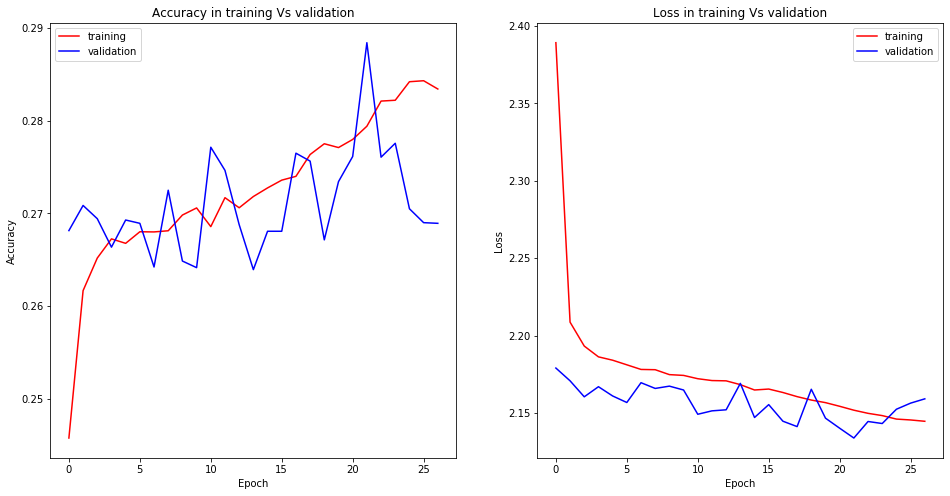

In [173]:
plot_history(history, 
             acc='acc', 
             val_acc='val_acc', 
             loss='loss', 
             val_loss='val_loss')

#### Convolutional based model

In [37]:
from keras.layers import Input, Embedding, Bidirectional, Dense, Conv1D, Flatten, MaxPool1D, concatenate, BatchNormalization, Dropout, SpatialDropout1D
from keras.models import Model
from keras import regularizers

#Define the inputs
comment_input = Input(shape=(vector_size,1), dtype='float32', name='comment_text')

# Put here ->  kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.2
# Add l2 first, evaluate if there is improvement 
conv = Conv1D(64, 3, activation='tanh', input_shape=(vector_size,), kernel_regularizer=regularizers.l2())(comment_input)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv = Conv1D(128, 3, activation='tanh')(conv)
conv = SpatialDropout1D(0.2)(conv)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv = Conv1D(128, 3, activation='tanh')(conv)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv = SpatialDropout1D(0.1)(conv)
conv = Conv1D(64, 3, activation='tanh')(conv)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv_output = Flatten()(conv)


#Apply a dense layers
# minimize the dense layers - maybe add one of 64
x = Dense(128, activation='relu')(conv_output)
#x = BatchNormalization()(x)
#x = Dense(100, activation='tanh')(x)
x = Dropout(0.5)(x)
#x = Dense(100, activation='tanh')(x)
#x = Dropout(0.4)(x)
#x = Dense(100, activation='tanh')(x)
#x = Dense(50, activation='tanh')(x)
#x = Dropout(0.2)(x)
#x = Dense(25, activation='tanh')(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(18, activation='softmax', name='prediction')(x)

model = Model(inputs=comment_input, outputs=main_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
comment_text (InputLayer)    (None, 1000, 1)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 998, 64)           256       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 499, 64)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 497, 128)          24704     
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 497, 128)          0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 248, 128)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 246, 128)          49280     
__________

In [38]:
%%time
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=15, min_delta=1e-7, restore_best_weights=True)

X_train_ann_rs = X_train_ann.reshape(X_train_ann.shape[0], X_train_ann.shape[1], 1)
history = model.fit(X_train_ann_rs, y_train_ann, epochs = 100, batch_size = 1000, validation_split= 0.2, callbacks=[early_stopping])

Train on 56000 samples, validate on 14000 samples
Epoch 1/100
56000/56000 [==============================] - 7s 121us/step - loss: 2.2491 - acc: 0.2910 - val_loss: 1.9052 - val_acc: 0.4091
Epoch 2/100
56000/56000 [==============================] - 6s 112us/step - loss: 1.8975 - acc: 0.4113 - val_loss: 1.7267 - val_acc: 0.4687
Epoch 3/100
56000/56000 [==============================] - 6s 112us/step - loss: 1.7575 - acc: 0.4547 - val_loss: 1.6295 - val_acc: 0.4918
Epoch 4/100
56000/56000 [==============================] - 6s 113us/step - loss: 1.6913 - acc: 0.4731 - val_loss: 1.5866 - val_acc: 0.5027
Epoch 5/100
56000/56000 [==============================] - 6s 113us/step - loss: 1.6432 - acc: 0.4844 - val_loss: 1.5630 - val_acc: 0.5079
Epoch 6/100
56000/56000 [==============================] - 6s 114us/step - loss: 1.6087 - acc: 0.4930 - val_loss: 1.5423 - val_acc: 0.5082
Epoch 7/100
56000/56000 [==============================] - 6s 114us/step - loss: 1.5824 - acc: 0.5008 - val_loss: 1.

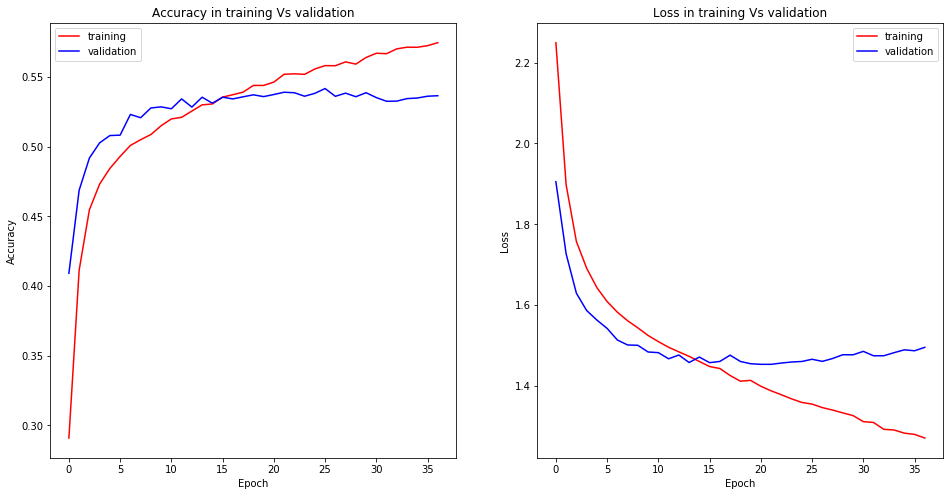

In [39]:
plot_history(history, 
             acc='acc', 
             val_acc='val_acc', 
             loss='loss', 
             val_loss='val_loss')

In [168]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])